### <center>Computer Laboratory I : Assignment 2-A<center>

### Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:
a. Pre-process the dataset.
<br>
b. Identify outliers.
<br>
c. Check the correlation.
<br>
d. Implement linear regression, Ridge and Lasso models.
<br>
e. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('uber.csv')

 ## 1. Pre-process the dataset.

In [3]:
df.shape

(200000, 9)

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.drop(columns=["Unnamed: 0", "key"], inplace=True)
df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1


In [6]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)

In [8]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [9]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [10]:
df = df.assign(hour = df.pickup_datetime.dt.hour,
               day = df.pickup_datetime.dt.day,
               month = df.pickup_datetime.dt.month,
               year = df.pickup_datetime.dt.year,
               dayofweek = df.pickup_datetime.dt.dayofweek)

In [11]:
df.head(4)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4


In [12]:
df = df.drop(["pickup_datetime"], axis =1)
df.head(1)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3


## claculate distance travelled

In [13]:
def filter_latitude(val):
    if val < -90 or val > 90:
         return np.nan
    else:
         return val
def filter_longitude(val):
     if val < -180 or val > 180:
        return np.nan
     else:
        return val

In [14]:
df['pickup_longitude'] = df['pickup_longitude'].apply(filter_longitude)
df['pickup_latitude'] = df['pickup_latitude'].apply(filter_latitude)
df['dropoff_longitude'] = df['dropoff_longitude'].apply(filter_longitude)
df['dropoff_latitude'] = df['dropoff_latitude'].apply(filter_latitude)
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10,2012,6
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3,2014,4
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6,2009,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5,2015,2


In [15]:
df.isnull().sum()

fare_amount          0
pickup_longitude     7
pickup_latitude      4
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
hour                 0
day                  0
month                0
year                 0
dayofweek            0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
year                 0
dayofweek            0
dtype: int64

In [18]:
# calculate the distance between pickup and dropoff using geopy library
from geopy.distance import great_circle
def distance_km(x):
    pickup = (x['pickup_latitude'], x['pickup_longitude'])
    dropoff = (x['dropoff_latitude'], x['dropoff_longitude'])
    return great_circle(pickup, dropoff).km

In [19]:
#pip install geopy

In [20]:
df['distance_km'] = df.apply(lambda x: distance_km(x), axis=1)

In [21]:
df.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] , inplace=True , axis= 1)

In [22]:
df.describe()

,fare_amount,passenger_count,hour,day,month,year,dayofweek,distance_km
count,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000
mean,11.359913,1.684536,13.491509,15.704667,6.281787,2011.742470,3.048373,20.560732
std,9.901884,1.386001,6.515484,8.687502,3.438949,1.856435,1.946961,379.620362
min,-52.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000,0.000000
25%,6.000000,1.000000,9.000000,8.000000,3.000000,2010.000000,1.000000,1.215174
50%,8.500000,1.000000,14.000000,16.000000,6.000000,2012.000000,3.000000,2.120843
75%,12.500000,2.000000,19.000000,23.000000,9.000000,2013.000000,5.000000,3.874819
max,499.000000,208.000000,23.000000,31.000000,12.000000,2015.000000,6.000000,8782.911013


In [23]:
df

,fare_amount,passenger_count,hour,day,month,year,dayofweek,distance_km
0,7.5,1,19,7,5,2015,3,1.683325
1,7.7,1,20,17,7,2009,4,2.457593
2,12.9,1,21,24,8,2009,0,5.036384
3,5.3,3,8,26,6,2009,4,1.661686
4,16.0,5,17,28,8,2014,3,4.475456
...,...,...,...,...,...,...,...,...
199995,3.0,1,10,28,10,2012,6,0.112210
199996,7.5,1,1,14,3,2014,4,1.875053
199997,30.9,2,0,29,6,2009,0,12.850337
199998,14.5,1,14,20,5,2015,2,3.539720


## 2. Identify outliers.

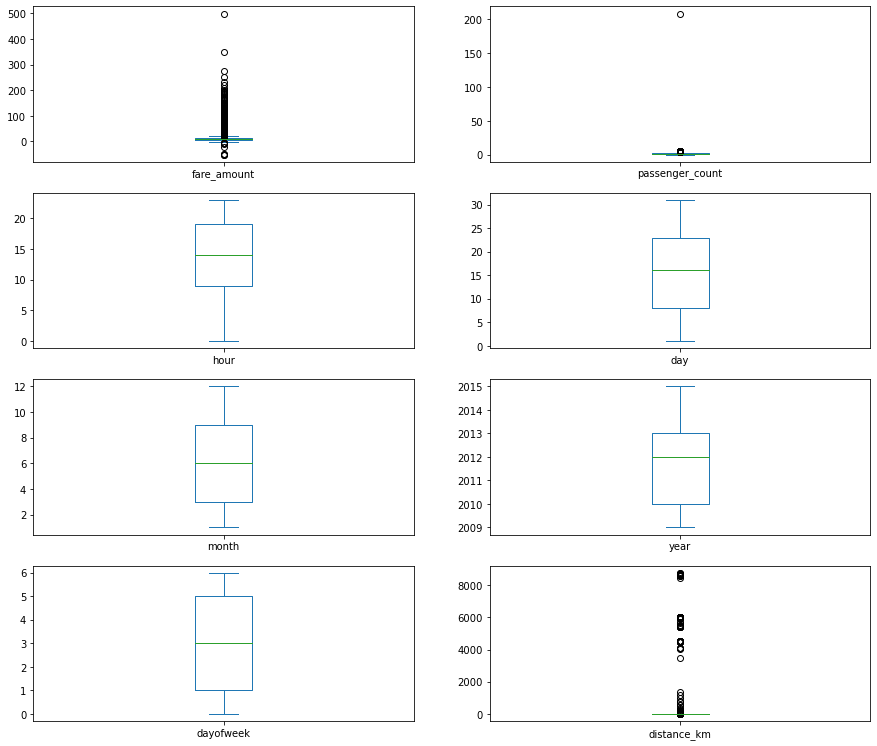

In [24]:
df.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [25]:
## handling the outliers with pandas
q1 = df['distance_km'].quantile(0.25)
q3 = df['distance_km'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 *iqr

In [26]:
df = df[(df['distance_km'] >= lower) & (df['distance_km']<=upper) ]

In [27]:
df.describe()

,fare_amount,passenger_count,hour,day,month,year,dayofweek,distance_km
count,183239.000000,183239.000000,183239.000000,183239.000000,183239.000000,183239.000000,183239.000000,183239.000000
mean,9.285238,1.682819,13.555100,15.708654,6.271236,2011.727700,3.046835,2.395799
std,5.911053,1.392388,6.475506,8.683891,3.443949,1.856319,1.941658,1.700166
min,-52.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000,0.000000
25%,5.700000,1.000000,9.000000,8.000000,3.000000,2010.000000,1.000000,1.150421
50%,8.000000,1.000000,14.000000,16.000000,6.000000,2012.000000,3.000000,1.945551
75%,11.300000,2.000000,19.000000,23.000000,9.000000,2013.000000,5.000000,3.246392
max,499.000000,208.000000,23.000000,31.000000,12.000000,2015.000000,6.000000,7.864245


In [28]:
df.drop(df[df['distance_km'] < 1].index, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp/ipykernel_14808/3624533874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['distance_km'] < 1].index, inplace=True)


In [29]:
# handileng the outliers with pandas
q1 = df['fare_amount'].quantile(0.25)
q3 = df['fare_amount'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 *iqr

In [30]:
df = df[(df['fare_amount'] >= lower) & (df['fare_amount']<=upper) ]

In [31]:
df.duplicated().sum()

0

In [32]:
df.shape

(142505, 8)

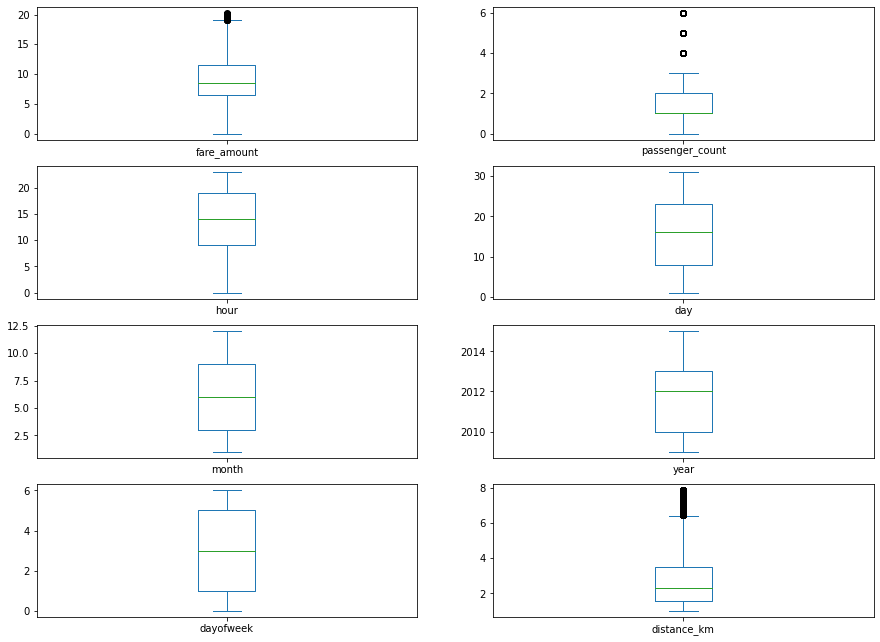

In [33]:
#Boxplot shows that dataset is free from outliers
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) 
plt.show()

## 3. Check the correlation.

In [34]:
#Function to find the correlation
corr = df.corr() 
corr

,fare_amount,passenger_count,hour,day,month,year,dayofweek,distance_km
fare_amount,1.000000,0.016217,-0.006557,0.004180,0.027419,0.172879,0.014031,0.786929
passenger_count,0.016217,1.000000,0.016680,0.002509,0.008179,0.003787,0.036991,0.004606
hour,-0.006557,0.016680,1.000000,0.005473,-0.001929,0.003749,-0.092066,-0.036452
day,0.004180,0.002509,0.005473,1.000000,-0.016140,-0.009829,0.005554,0.005673
month,0.027419,0.008179,-0.001929,-0.016140,1.000000,-0.114530,-0.011114,-0.000852
year,0.172879,0.003787,0.003749,-0.009829,-0.114530,1.000000,0.006339,-0.033821
dayofweek,0.014031,0.036991,-0.092066,0.005554,-0.011114,0.006339,1.000000,0.040789
distance_km,0.786929,0.004606,-0.036452,0.005673,-0.000852,-0.033821,0.040789,1.000000


## 4. Implement linear regression, Ridge and Lasso models.

In [35]:
# Dividing the dataset into feature and target values 
df_x = df.drop('fare_amount', axis=1)
df_y = df['fare_amount']

In [36]:
# Dividing the dataset into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1)

In [37]:
df

,fare_amount,passenger_count,hour,day,month,year,dayofweek,distance_km
0,7.5,1,19,7,5,2015,3,1.683325
1,7.7,1,20,17,7,2009,4,2.457593
2,12.9,1,21,24,8,2009,0,5.036384
3,5.3,3,8,26,6,2009,4,1.661686
4,16.0,5,17,28,8,2014,3,4.475456
...,...,...,...,...,...,...,...,...
199993,9.5,1,19,29,9,2012,5,2.640897
199994,12.0,1,14,31,1,2014,4,1.122879
199996,7.5,1,1,14,3,2014,4,1.875053
199998,14.5,1,14,20,5,2015,2,3.539720


# Linear

In [38]:
from sklearn.linear_model import LinearRegression

# initialize the linear regression model
lin = LinearRegression()

# Train the model with our training data
lin.fit(x_train, y_train)

LinearRegression()

In [39]:
y_pred_lin = lin.predict(x_test)
print(y_pred_lin)

[ 7.6025532  10.80769803  6.269565   ...  9.82895113 10.12153752
  6.95267273]


## Ridge

In [40]:
from sklearn.linear_model import Ridge

# initialize the linear regression model
Ridge = Ridge()

# Train the model with our training data
Ridge.fit(x_train, y_train)

Ridge()

In [41]:
y_pred_ridge = Ridge.predict(x_test)
print(y_pred_ridge)

[ 7.60256051 10.80769185  6.26957658 ...  9.82894908 10.12153483
  6.95268204]


## Lasso

In [42]:
from sklearn.linear_model import Lasso

# initialize the linear regression model
Lasso = Lasso()

# Train the model with our training data
Lasso.fit(x_train, y_train)

Lasso()

In [43]:
y_pred_lasso = Lasso.predict(x_test)
print(y_pred_lasso)

[ 8.38089859 10.56399735  7.41281436 ...  9.74014615  9.76347661
  7.15928564]


## 5. Evaluate the models and compare their respective scores like R2, RMSE, etc

In [44]:
from sklearn import metrics 
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R-squared (R2) for each model
linear_reg_r2 = r2_score(y_test, y_pred_lin)
ridge_reg_r2 = r2_score(y_test, y_pred_ridge)
lasso_reg_r2 = r2_score(y_test, y_pred_lasso)

# Calculate RMSE for each model
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
ridge_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
lasso_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f'Linear Regression R2: {linear_reg_r2}, RMSE: {linear_reg_rmse}')
print(f'Ridge Regression R2: {ridge_reg_r2}, RMSE: {ridge_reg_rmse}')
print(f'Lasso Regression R2: {lasso_reg_r2}, RMSE: {lasso_reg_rmse}')

Linear Regression R2: 0.6583437373847896, RMSE: 2.1218495960657635
Ridge Regression R2: 0.6583437171122498, RMSE: 2.1218496590168705
Lasso Regression R2: 0.5946862533380113, RMSE: 2.3110831452161595
